# "Facility" Deployment: Message Bus, MongoDB, intake server

## Scenario

This is an approximation of a deployment "at scale," such as at a large experimental facility.

Bluesky is configured to dispatch the documents generated during data acquisition to a (very lightweight) **message bus**. A **consumer** is listening to the message bus and inserting Documents into a **MongoDB** instance, which stores the data at rest.

An **intake server**, which has access to the MongoDB and to any externally-stored files generated by large detectors, serves the data to users over HTTP. In this demo deployment, everything happens to be on the same machine, but it need not be. The user will never directly connect to the MongoDB or directly access the filesystem where data files are stored.
 
## Setup: Acquire some sample data.

For data acquisition (but not for data access!) we assume that we have direct access to MongoDB (or some message queue that has a sink into MongoDB).

In [1]:
%matplotlib notebook
from bluesky.utils import install_nb_kicker
install_nb_kicker()

from bluesky import RunEngine
from bluesky.plans import scan
from bluesky.preprocessors import SupplementalData
from ophyd.sim import motor, det, direct_img, img
from bluesky.callbacks.zmq import Publisher
import pymongo
from bluesky.callbacks.mpl_plotting import LivePlot

RE = RunEngine({})
sd = SupplementalData(baseline=[motor])
RE.preprocessors.append(sd)
publish_to_message_bus = Publisher('localhost:5577')
RE.subscribe(publish_to_message_bus)

0

In [43]:
!supervisorctl -c supervisor/supervisord.conf status

bluesky-0MQ-proxy                RUNNING   pid 3179, uptime 0:00:06
consumer                         RUNNING   pid 3178, uptime 0:00:06
intake-server                    RUNNING   pid 3180, uptime 0:00:06


<IPython.core.display.Javascript object>


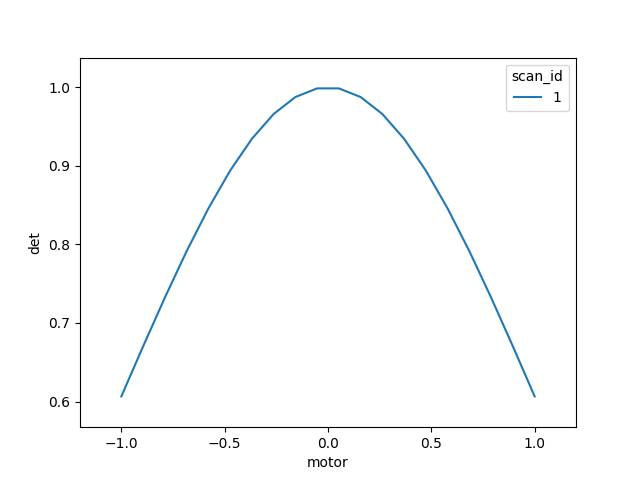

In [2]:

uid, = RE(scan([det], motor, -1, 1, 20), LivePlot('det', 'motor'))

In [3]:
from intake import Catalog
import intake_bluesky.mongo_layout1

cat = Catalog('intake://localhost:5000')

In [6]:
cat['xyz'][uid]().primary.read()

<xarray.Dataset>
Dimensions:                   (time: 20)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Data variables:
    det                       (time) float64 0.6065 0.6701 ... 0.6701 0.6065
    det:det                   (time) float64 0.6065 0.6065 ... 0.6065 0.6065
    motor                     (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    motor:motor_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor:motor_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor_setpoint            (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
    uid                       (time) <U36 '5ac1caae-0fe2-428b-811a-dce5bff36b78' ... '3a626d65-e0e3-4e69-8904-a0a61d807a8a'

## Open an intake Catalog.

We could use intake to access the data _directly_ like this, though we will probably never do so at NSLS-II.

In [5]:
from intake_bluesky.mongo_layout1 import BlueskyMongoCatalog

cat = BlueskyMongoCatalog(client['mds'], client['assets'], name='my_beamline')

In [6]:
cat

<Intake catalog: my_beamline>

In [7]:
run = cat[uid]

In [8]:
run

<Catalog Entry: a5677459-c634-4b9e-a0fe-418c2c771fa9>

In [9]:
run()

Run Catalog
  uid='a5677459-c634-4b9e-a0fe-418c2c771fa9'
  exit_status='success'
  2019-02-14 19:53:17.910 -- 2019-02-14 19:53:18.348
  Streams:
    * primary
    * baseline

In [10]:
run._entries

{'primary': <Catalog Entry: primary>, 'baseline': <Catalog Entry: baseline>}

In [11]:
cat[uid].primary.read()

<xarray.Dataset>
Dimensions:                   (time: 20)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Data variables:
    motor                     (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    motor_setpoint            (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    det                       (time) float64 0.6065 0.6701 ... 0.6701 0.6065
    motor:motor_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor:motor_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    det:det                   (time) float64 0.6065 0.6065 ... 0.6065 0.6065
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
    uid                       (time) <U36 'd5093c7a-2792-4c51-8d2f-c355a1da98a7' ... 'aa6e016e-865d-4f5a-b887-7c984550920b'

In [12]:
run.primary.to_dask()

<xarray.Dataset>
Dimensions:                   (time: 20)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Data variables:
    motor                     (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    motor_setpoint            (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    det                       (time) float64 0.6065 0.6701 ... 0.6701 0.6065
    motor:motor_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor:motor_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    det:det                   (time) float64 0.6065 0.6065 ... 0.6065 0.6065
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
    uid                       (time) <U36 'd5093c7a-2792-4c51-8d2f-c355a1da98a7' ... 'aa6e016e-865d-4f5a-b887-7c984550920b'

In [13]:
run.primary.read().to_dataframe().head()

,motor,motor_setpoint,det,motor:motor_velocity,motor:motor_acceleration,det:det,seq_num,uid
time,,,,,,,,
1.550174e+09,-1.000000,-1.000000,0.606531,1,1,0.606531,1,d5093c7a-2792-4c51-8d2f-c355a1da98a7
1.550174e+09,-0.894737,-0.894737,0.670134,1,1,0.606531,2,d6c079e6-a96e-4bce-8bac-f885b8c35766
1.550174e+09,-0.789474,-0.789474,0.732249,1,1,0.606531,3,1c7f7bdd-fad3-40b3-b086-92fc80c4d711
1.550174e+09,-0.684211,-0.684211,0.791305,1,1,0.606531,4,69d62ee5-8aab-4e14-bb12-b22f03ba2419
1.550174e+09,-0.578947,-0.578947,0.845700,1,1,0.606531,5,b85dca71-71eb-498f-9a69-534e1c1901dc


Each entry in this Catalog represents one scan. There are too many to list them all. (We could _try_ but it would take a long time and probably run out of memory.)

We can find scans of interest in a couple ways.

## Progressive Search

We can search ``cat`` by passing it a Mongo Query. The result is another Catalog, with a subset of the entries in ``cat``.

In [14]:
search_results = cat.search({'plan_name': 'scan'})
list(search_results)

['50495729-7296-4688-be73-016d4e95c696',
 'a5677459-c634-4b9e-a0fe-418c2c771fa9']

We can progressively serach, generating yet another Catalog.

In [15]:
import time
recent_counts = search_results.search({'time': {'$gt': time.time() - 30}})
len(list(recent_counts))

2

Having narrowed the results to a small Catalog, we can list them.

In [16]:
list(recent_counts)

['50495729-7296-4688-be73-016d4e95c696',
 'a5677459-c634-4b9e-a0fe-418c2c771fa9']

## Random access by unique ID (`uid`), recency, and `scan_id`

We can access entries by their unique ID "name" as in:

In [17]:
entry = cat[uid]  # uid we captured above during data acquisition
entry

<Catalog Entry: a5677459-c634-4b9e-a0fe-418c2c771fa9>

We can also access entries by *recency* with this syntactic sugar:

In [18]:
recent_counts[-1]

<Catalog Entry: 50495729-7296-4688-be73-016d4e95c696>

A positive integer matches the most recent entry with the corresponding ``scan_id`` (not necessarily globally unique!)

In [19]:
cat[1]

<Catalog Entry: a5677459-c634-4b9e-a0fe-418c2c771fa9>

Both of these "tricks" are _not_ general features of intake Catalogs, but as shown we can support them, for the sake of convenience and of continuity with databroker usage patterns.

## Metadata

The entry's metadata is available via ``entry.metadata``. Notice that this includes ``entry.metadata.start`` and ``entry.metadata.stop``, the documents generated at the beginning and end of the corresponding scan.

In [20]:
entry.metadata

{'start': {'uid': 'a5677459-c634-4b9e-a0fe-418c2c771fa9',
  'time': 1550173997.9105096,
  'motors': ['motor'],
  'plan_pattern_module': 'bluesky.plan_patterns',
  'hints': {'dimensions': [[['motor'], 'primary']]},
  'plan_pattern': 'inner_product',
  'num_points': 20,
  'detectors': ['det'],
  'plan_pattern_args': {'num': 20,
   'args': ["SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])",
    -1,
    1]},
  'plan_type': 'generator',
  'plan_args': {'detectors': ["SynGauss(name='det', value=1.0, timestamp=1550173997.77577)"],
   'num': 20,
   'args': ["SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])",
    -1,
    1],
   'per_step': 'None'},
  'scan_id': 1,
  'plan_name': 'scan',
  'num_intervals': 19},
 'stop': {'run_start': 'a5677459-c634-4b9e-a0fe-418c2c771fa9',
  'time': 1550173998.3486795,
  'uid': '6e5b8491-de03-4415-80da-c74b7c43115f',
  'e

## Accessing Data

Calling an Entry like `entry()` or equivalently `entry.get()` returns the DataSource for that Entry. The DataSource corresponding to one scan is itself a Catalog, named for with the `uid`.

In [21]:
entry()

Run Catalog
  uid='a5677459-c634-4b9e-a0fe-418c2c771fa9'
  exit_status='success'
  2019-02-14 19:53:17.910 -- 2019-02-14 19:53:18.348
  Streams:
    * primary
    * baseline

That Catalog has one entry for each stream of data captured during that scan. (Typically there is a ``'primary'`` stream and potentially others, but this is just a convention.) As with all Catalogs, we can look at its contents.

In [22]:
list(entry())

['primary', 'baseline']

In [23]:
entry.primary()

<Intake catalog: Stream 'primary' from Run a5677459...>

We can pull the data from the 'primary' stream all at once:

In [24]:
entry().primary().read()

<xarray.Dataset>
Dimensions:                   (time: 20)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Data variables:
    motor                     (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    motor_setpoint            (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    det                       (time) float64 0.6065 0.6701 ... 0.6701 0.6065
    motor:motor_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor:motor_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    det:det                   (time) float64 0.6065 0.6065 ... 0.6065 0.6065
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
    uid                       (time) <U36 'd5093c7a-2792-4c51-8d2f-c355a1da98a7' ... 'aa6e016e-865d-4f5a-b887-7c984550920b'

At this point, we have "left" intake. We have an ordinary `xarray.Dataset` object, which we can use to do any further slicing or drilling down. This `Dataset` contains numpy arrays. Alternatively, we can ask intake for a `Dataset` of _dask_ arrays, which will defer pulling the data from the server until called up to compute a result.

In [25]:
entry().primary().to_dask()  # an xarray of dask.arrays

<xarray.Dataset>
Dimensions:                   (time: 20)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Data variables:
    motor                     (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    motor_setpoint            (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    det                       (time) float64 0.6065 0.6701 ... 0.6701 0.6065
    motor:motor_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor:motor_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    det:det                   (time) float64 0.6065 0.6065 ... 0.6065 0.6065
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
    uid                       (time) <U36 'd5093c7a-2792-4c51-8d2f-c355a1da98a7' ... 'aa6e016e-865d-4f5a-b887-7c984550920b'

For example, converting the `xarray.Dataset` to a `pandas.DataFrame` will prompt dask to materialize the data:

In [26]:
entry().primary().to_dask().to_dataframe()

,motor,motor_setpoint,det,motor:motor_velocity,motor:motor_acceleration,det:det,seq_num,uid
time,,,,,,,,
1.550174e+09,-1.000000,-1.000000,0.606531,1,1,0.606531,1,d5093c7a-2792-4c51-8d2f-c355a1da98a7
1.550174e+09,-0.894737,-0.894737,0.670134,1,1,0.606531,2,d6c079e6-a96e-4bce-8bac-f885b8c35766
1.550174e+09,-0.789474,-0.789474,0.732249,1,1,0.606531,3,1c7f7bdd-fad3-40b3-b086-92fc80c4d711
1.550174e+09,-0.684211,-0.684211,0.791305,1,1,0.606531,4,69d62ee5-8aab-4e14-bb12-b22f03ba2419
1.550174e+09,-0.578947,-0.578947,0.845700,1,1,0.606531,5,b85dca71-71eb-498f-9a69-534e1c1901dc
1.550174e+09,-0.473684,-0.473684,0.893876,1,1,0.606531,6,f03bb606-dafc-40a6-b232-fd2100bd5b42
1.550174e+09,-0.368421,-0.368421,0.934385,1,1,0.606531,7,656c6a44-5b6b-478c-b125-fbfd355023a0
1.550174e+09,-0.263158,-0.263158,0.965967,1,1,0.606531,8,70f5d89c-54d6-4000-8134-142e75b8d34c
1.550174e+09,-0.157895,-0.157895,0.987612,1,1,0.606531,9,dea832b7-e194-4778-b2b0-daaeabe95aa7


We can look at the data from the other stream, 'baseline'.

In [27]:
entry().baseline.read()

<xarray.Dataset>
Dimensions:                   (time: 2)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09
Data variables:
    motor                     (time) float64 0.0 1.0
    motor_setpoint            (time) float64 0.0 1.0
    motor:motor_velocity      (time) int64 1 1
    motor:motor_acceleration  (time) int64 1 1
    seq_num                   (time) int64 1 2
    uid                       (time) <U36 '3709879b-bde7-4075-829a-5225a776bd57' '91e1c5c4-03f6-4bd7-954f-3a1f8bf2aa71'

Or merge all the stream together into one `xarray.Dataset`:

In [28]:
import xarray

xarray.merge(entry()[key].read() for key in entry())

<xarray.Dataset>
Dimensions:                   (time: 22)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Data variables:
    motor                     (time) float64 0.0 -1.0 -0.8947 ... 0.8947 1.0 1.0
    motor_setpoint            (time) float64 0.0 -1.0 -0.8947 ... 0.8947 1.0 1.0
    det                       (time) float64 nan 0.6065 0.6701 ... 0.6065 nan
    motor:motor_velocity      (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    motor:motor_acceleration  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    det:det                   (time) float64 nan 0.6065 0.6065 ... 0.6065 nan
    seq_num                   (time) float64 1.0 1.0 2.0 3.0 ... 19.0 20.0 2.0
    uid                       (time) object '3709879b-bde7-4075-829a-5225a776bd57' ... '91e1c5c4-03f6-4bd7-954f-3a1f8bf2aa71'

which creates a "block matrix" sorted on time, clearly visible when cast into a DataFrame:

In [29]:
xarray.merge(entry()[key].read() for key in entry()).to_dataframe()

,motor,motor_setpoint,det,motor:motor_velocity,motor:motor_acceleration,det:det,seq_num,uid
time,,,,,,,,
1.550174e+09,0.000000,0.000000,NaN,1.0,1.0,NaN,1.0,3709879b-bde7-4075-829a-5225a776bd57
1.550174e+09,-1.000000,-1.000000,0.606531,1.0,1.0,0.606531,1.0,d5093c7a-2792-4c51-8d2f-c355a1da98a7
1.550174e+09,-0.894737,-0.894737,0.670134,1.0,1.0,0.606531,2.0,d6c079e6-a96e-4bce-8bac-f885b8c35766
1.550174e+09,-0.789474,-0.789474,0.732249,1.0,1.0,0.606531,3.0,1c7f7bdd-fad3-40b3-b086-92fc80c4d711
1.550174e+09,-0.684211,-0.684211,0.791305,1.0,1.0,0.606531,4.0,69d62ee5-8aab-4e14-bb12-b22f03ba2419
1.550174e+09,-0.578947,-0.578947,0.845700,1.0,1.0,0.606531,5.0,b85dca71-71eb-498f-9a69-534e1c1901dc
1.550174e+09,-0.473684,-0.473684,0.893876,1.0,1.0,0.606531,6.0,f03bb606-dafc-40a6-b232-fd2100bd5b42
1.550174e+09,-0.368421,-0.368421,0.934385,1.0,1.0,0.606531,7.0,656c6a44-5b6b-478c-b125-fbfd355023a0
1.550174e+09,-0.263158,-0.263158,0.965967,1.0,1.0,0.606531,8.0,70f5d89c-54d6-4000-8134-142e75b8d34c


## N-dimensional Data (e.g. images)

Higher-dimensional data does not have to be treated specially. It can sit in an `xarray.Dataset` as well. As above, we can use `read()` to fetch the data immediately or `to_dask()` to fetch it lazily.

In [30]:
entry = cat[direct_img_uid]  # uid captured during data acquisition above
dataset = entry().primary().to_dask()
dataset

<xarray.Dataset>
Dimensions:                   (dim_0: 10, dim_1: 10, time: 20)
Coordinates:
  * time                      (time) float64 1.55e+09 1.55e+09 ... 1.55e+09
Dimensions without coordinates: dim_0, dim_1
Data variables:
    motor                     (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    motor_setpoint            (time) float64 -1.0 -0.8947 -0.7895 ... 0.8947 1.0
    img                       (time, dim_0, dim_1) float64 1.0 1.0 ... 1.0 1.0
    motor:motor_velocity      (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    motor:motor_acceleration  (time) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    img:img                   (time, dim_0, dim_1) float64 1.0 1.0 ... 1.0 1.0
    seq_num                   (time) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20
    uid                       (time) <U36 '86c93f77-c36f-41ae-939b-89ae35b434f2' ... '038ee488-c7c4-456a-a680-d0a87f86aa69'

## The `xarray.Dataset` is a very useful container.

It has a nice string representation, as shown above. We can access specific dimensions:

In [31]:
dataset['img']

<xarray.DataArray 'img' (time: 20, dim_0: 10, dim_1: 10)>
array([[[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       ...,

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]])
Coordinates:
  * time     (time) float64 1.55e+09 1.55e+09 1.55e+09 ... 1.55e+09 1.55e+09
Dimensions without coordinates: dim_0, dim_1

Do math along named dimensions:

In [32]:
dataset['img'].sum('time')

<xarray.DataArray 'img' (dim_0: 10, dim_1: 10)>
array([[20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]])
Dimensions without coordinates: dim_0, dim_1

Slice along named dimensions:

In [33]:
dataset['img'].sel(dim_0=slice(0, 3), dim_1=slice(5, 10))

<xarray.DataArray 'img' (time: 20, dim_0: 3, dim_1: 5)>
array([[[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       ...,

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]])
Coordinates:
  * time     (time) float64 1.55e+09 1.55e+09 1.55e+09 ... 1.55e+09 1.55e+09
Dimensions without coordinates: dim_0, dim_1

In [34]:
documents = run.read_canonical()

In [35]:
documents

<generator object RunCatalog.read_canonical at 0x7fe80f77e8e0>

In [36]:
next(iter(documents))

('start',
 {'uid': 'a5677459-c634-4b9e-a0fe-418c2c771fa9',
  'time': 1550173997.9105096,
  'motors': ['motor'],
  'plan_pattern_module': 'bluesky.plan_patterns',
  'hints': {'dimensions': [[['motor'], 'primary']]},
  'plan_pattern': 'inner_product',
  'num_points': 20,
  'detectors': ['det'],
  'plan_pattern_args': {'num': 20,
   'args': ["SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])",
    -1,
    1]},
  'plan_type': 'generator',
  'plan_args': {'detectors': ["SynGauss(name='det', value=1.0, timestamp=1550173997.77577)"],
   'num': 20,
   'args': ["SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])",
    -1,
    1],
   'per_step': 'None'},
  'scan_id': 1,
  'plan_name': 'scan',
  'num_intervals': 19})

<IPython.core.display.Javascript object>


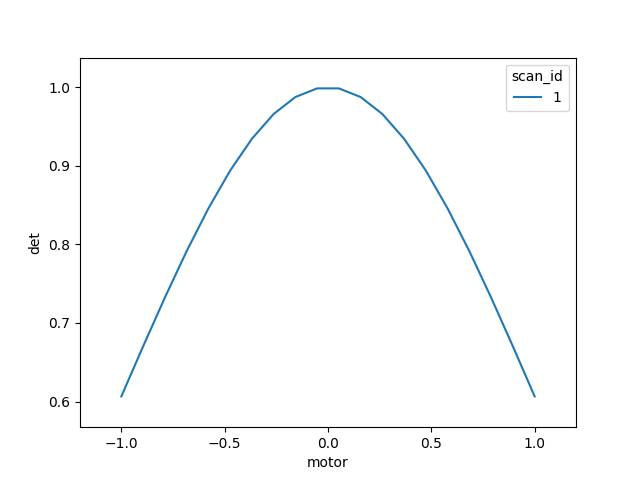

In [37]:
live_plot = LivePlot('det', 'motor')
for name, doc in run.read_canonical():
    live_plot(name, doc)